In [1]:
import os

DATA_DIR = os.path.join("english")

In [2]:
next(os.walk(os.path.join(DATA_DIR, 'Durian')))

('english/Durian',
 [],
 ['aligned.swc',
  'audio.ogg',
  'audiometa.txt',
  'info.json',
  'wiki.html',
  'wiki.txt',
  'wiki.xml'])

In [3]:
import xml.etree.ElementTree as ET
from typing import List

import numpy as np


class PronunciationTiming(object):

    def __init__(self, word: str, start: int, end: int) -> None:
        self.word = word
        self.start = start
        self.end = end

class SWC(object):

    def __init__(self, swc_path: str) -> None:
        self.tree = ET.parse(swc_path)
        self.timings = []

    def get_timings(self) -> List[PronunciationTiming]:
        if len(self.timings) > 0:
            return self.timings
        # https://www.geeksforgeeks.org/xml-parsing-python/
        root = self.tree.getroot()
        doc = root.find('d')

        for p in doc.findall('p'):
            for s in p.findall('s'):
                for t in s.findall('t'):
                    for n in t.findall('n'):
                        attribs = n.attrib
                        if 'pronunciation' not in attribs \
                            or 'start' not in attribs or 'end' not in attribs:
                            continue
                        self.timings.append(PronunciationTiming(
                            attribs['pronunciation'],
                            int(attribs['start']),
                            int(attribs['end'])))
        return self.timings

In [4]:
from typing import Tuple

from pydub import AudioSegment


def split_clip(audio: AudioSegment, swc: SWC
               ) -> Tuple[List[str], List[AudioSegment]]:
    words = []
    clips = []
    for p in swc.get_timings():
        words.append(p.word)
        clip = audio[p.start:p.end]
        # https://github.com/jiaaro/pydub/blob/master/API.markdown#audiosegmentget_array_of_samples
        # clip = audio[p.start:p.end].get_array_of_samples()
        # fp_arr = np.array(clip).T.astype(np.float32)
        # fp_arr /= np.iinfo(clip.typecode).max
        clips.append(clip)
    return words, clips

audio = AudioSegment.from_ogg('english/Durian/audio.ogg')
# print(audio.channels, audio.frame_rate)
swc = SWC('english/Durian/aligned.swc')
split_clip(audio, swc)

(['trees',
  'from',
  'the',
  'genus',
  'Durio',
  'belonging',
  'to',
  'the',
  'Durionaceae',
  'family',
  'Widely',
  'known',
  'revered',
  'in',
  'Southeast',
  'Asia',
  'as',
  'the',
  'King',
  'of',
  'Fruits',
  'the',
  'fruit',
  'is',
  'distinctive',
  'large',
  'size',
  'unique',
  'odour',
  'and',
  'formidable',
  'thorn',
  'covered',
  'husk',
  'fruit',
  'can',
  'grow',
  'up',
  'to',
  'thirty',
  'centimetres',
  'twelve',
  'in',
  'long',
  'and',
  'centimetres',
  'six',
  'in',
  'in',
  'diameter',
  'and',
  'typically',
  'weighs',
  'one',
  'three',
  'kilograms',
  'to',
  'seven',
  'l',
  'b',
  'Its',
  'shape',
  'ranges',
  'from',
  'oblong',
  'to',
  'round',
  'the',
  'colour',
  'of',
  'its',
  'husk',
  'green',
  'to',
  'brown',
  'and',
  'its',
  'flesh',
  'pale',
  'yellow',
  'to',
  'red',
  'depending',
  'on',
  'the',
  'species',
  'edible',
  'flesh',
  'emits',
  'distinctive',
  'odour',
  'strong',
  'and',
  

In [5]:
class PronunciationClip(object):
    def __init__(self, word: str, audio: AudioSegment) -> None:
        self.word = word
        self.audio = audio

    def __repr__(self) -> str:
        return f"PronunciationClip({repr(self.word)}, {repr(self.audio)})"

In [6]:
clips = []

for dir in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir)
    if not os.path.isdir(path):
        continue
    files = os.listdir(path)
    if 'audio.ogg' not in files or 'aligned.swc' not in files:
        continue
    try:
        audio = AudioSegment.from_ogg(os.path.join(path, 'audio.ogg'))
    except:  # noqa: E722
        print(f'Failed to decode file: {os.path.join(path, "audio.ogg")}')
        continue
    swc = SWC(os.path.join(path, 'aligned.swc'))
    words, pcms = split_clip(audio, swc)
    for w, c in zip(words, pcms):
        clips.append(PronunciationClip(w, c))

    # arbitrary limit
    if len(clips) > 5000:
        break

In [7]:
print(len(clips))
clips[0]

5126


PronunciationClip('I', <pydub.audio_segment.AudioSegment object at 0x7fea2daa3cd0>)

In [8]:
# https://github.com/mcdermottLab/pycochleagram
import pycochleagram.cochleagram as cgram
from scipy import ndimage

N_FILTERS = 50
LO_LIM = 30
HI_LIM = 7860
SAMPLE_RATE = 16000

def gen_clip(audio: AudioSegment, duration: int = 2000) -> AudioSegment:
    clip = AudioSegment.silent(duration=duration, frame_rate=SAMPLE_RATE)
    audio_duration = len(audio)
    offset = max(0, duration / 2 - (audio_duration / 2))
    return clip.overlay(audio, offset)

def audio_to_cgram(audio: AudioSegment) -> np.array:
    # TODO: find audio input type for cochleagram (8-bit integer PCM?)
    arr = np.array(audio.get_array_of_samples())
    return cgram.human_cochleagram(arr, audio.frame_rate or SAMPLE_RATE,
                                   N_FILTERS, LO_LIM, HI_LIM, 4, downsample=200)

def aa_cgram(cochleagram: np.ndarray, size: int = 256) -> np.ndarray:
    f, t = cochleagram.shape
    kx = size / f
    ky = size / t
    return ndimage.zoom(cochleagram, (kx, ky))

# a = gen_clip(clips[0].audio)
# c = audio_to_cgram(a)
# aa = aa_cgram(c)
# c.shape, aa.shape # 211x400, 256x256


In [9]:
def overlay_noise(snr: float, signal: AudioSegment, noise: AudioSegment
                  ) -> AudioSegment:
    signal = signal.normalize()
    gain = snr - signal.dBFS + noise.dBFS
    scaled_noise = noise.apply_gain(-gain)
    return signal.overlay(scaled_noise, loop=True)

# noise = AudioSegment.from_file('audio/outside_rural/snipped119_start_240_end_250.wav')
# overlay_noise(2.0, gen_clip(clips[0].audio), noise)

In [10]:
freq_dict = {}
for pc in clips:
    freq_dict[pc.word] = freq_dict.get(pc.word, 0) + 1
freq_dict

{'I': 2,
 'Cant': 1,
 'Get': 1,
 'No': 2,
 'Satisfaction': 1,
 'United': 7,
 'Kingdom': 1,
 'as': 30,
 'well': 4,
 'it': 13,
 'was': 73,
 'the': 241,
 'Rolling': 1,
 'Stones': 1,
 'fourth': 4,
 'UK': 1,
 'Despite': 1,
 'its': 18,
 'success': 2,
 'song': 1,
 'controversial': 2,
 'in': 111,
 'day': 3,
 'for': 31,
 'anti': 1,
 'establishment': 1,
 'and': 133,
 'suggestive': 1,
 'lyrics': 1,
 'decades': 1,
 'researchers': 1,
 'of': 141,
 'mathematics': 1,
 'education': 2,
 'rational': 1,
 'numbers': 1,
 'such': 8,
 'constructions': 1,
 'can': 6,
 'also': 5,
 'prove': 1,
 'that': 35,
 'object': 3,
 'which': 17,
 'reasonably': 1,
 'be': 13,
 'called': 2,
 'sixty': 9,
 'four': 25,
 'scale': 6,
 'is': 43,
 'approximate': 1,
 'size': 1,
 'popular': 2,
 'Matchbox': 1,
 'model': 2,
 'cars': 5,
 'Other': 2,
 'brands': 1,
 'Die': 1,
 'cast': 1,
 'toys': 1,
 'include': 5,
 'Wheels': 1,
 'Ertl': 1,
 'Code': 1,
 'three': 24,
 'Johnny': 2,
 'Lightning': 2,
 'Jada': 1,
 'Toys': 1,
 'Some': 2,
 'Slot': 1

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe9ec782be0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe9ec790040>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe9ec782940>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe9ec790580>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe9ec790820>],
 'means': []}

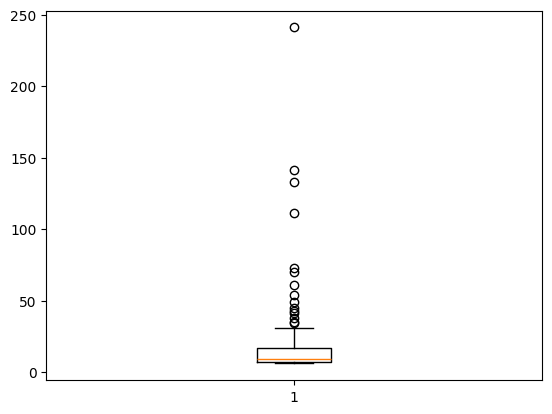

In [14]:
import matplotlib.pyplot as plt

wf = dict(filter(lambda x: x[1] > 5, freq_dict.items()))

plt.boxplot(wf.values())

In [12]:
for w, f in freq_dict.items():
    if f < 25:
        continue
    print(w, f)

as 30
was 73
the 241
in 111
for 31
and 133
of 141
that 35
four 25
is 43
one 34
two 49
on 54
thousand 27
by 41
a 61
to 70
nineteen 45
hundred 29
from 26
twenty 29
seven 25
with 28
five 38


In [13]:
freqs = set(freq_dict.values())
freqs

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 17,
 18,
 19,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 34,
 35,
 38,
 41,
 43,
 45,
 49,
 54,
 61,
 70,
 73,
 111,
 133,
 141,
 241}